# Gath - Geva Clustering

In [2]:

import numpy as np

First thing first, let's use the generator tools from previous works

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def get_random_covariance(d):
    """
    Function to generate a random, valid covariance matrix of size d x d
    """
    sigma = np.random.rand(d, d) - 0.5
    sigma = np.dot(sigma, sigma.T)  # make the matrix symmetric
    return sigma


def get_random_gaussian_dist(d, distance=5):
    """
     generate a random Gaussian distribution with mean mu and covariance matrix sigma
    The distance parameter specifies the distance of the mean from the origin
    """
    sigma = get_random_covariance(d)  # generate a random covariance matrix
    mu = np.array(np.random.rand(d)) * distance  # generate a random mean
    return mu, sigma


def generate_normal_datapoint(guaussian_dist):
    """
     generate a single datapoint from a Gaussian distribution with mean and covariance matrix guaussian_dist
    """
    mean = guaussian_dist[0]
    cov = guaussian_dist[1]
    dp = np.random.multivariate_normal(mean, cov, check_valid='warn', tol=1e-8)
    return dp


def generate_gaussian_cluster(guaussian_dist, k,d = 2, dataset=None):
    """
    Function to generate a cluster of k datapoints from the Gaussian distribution guaussian_dist
    The dataset parameter can be used to append the generated cluster to an existing dataset
    gauss_dist is a tuple of the form (mean, covariance matrix)
    """
    cluster = np.empty((0, d))  # initialize an empty array to store the datapoints
    for i in range(k):
        p = generate_normal_datapoint(guaussian_dist)  # generate a single datapoint
        cluster = np.append(cluster, [p], axis=0)  # add the datapoint to the cluster
    if dataset:
        dataset = np.append(dataset, cluster)  # append the cluster to an existing dataset, if provided
    return cluster


def plot_loss(loss):
    plt.figure()
    plt.plot(range(len(loss)),loss)
    plt.title("loss vs. iteration no.")
    plt.xlabel("iteration")
    plt.ylabel("|loss|")
    plt.show()

def get_rand_centroids(K,d):
    centroids = np.random.rand(K, d)
    return centroids

In [274]:

def generate_clusters(k, d = 2,N =600, distance = 2):
    """
    generate k clusters of d-dimensional data

    :param k:           number of clusters
    :param d:           dimension of the data
    :param distance:    expected distance of the mean from the origin
    :return:            clusters - a list of clusters, where each cluster is a numpy array of datapoints
                        data - a numpy array of all the datapoints
                        phi - a numpy array of the priors of each cluster
                        sigma - a numpy array of the covariance matrices of each cluster
    """
    phi = np.random.rand(k)
    phi = phi/np.sum(phi)
    print(phi)

    # random distributions
    distributions = [get_random_gaussian_dist(d,distance) for i in range(k)]
    print(distributions[0])
    # generate clusters
    clusters = [generate_gaussian_cluster(distribution,int(phi[i]*N),d) for i, distribution in enumerate(distributions)]

    sigma = [distribution[1] for distribution in distributions]
    data = np.concatenate(clusters,axis=0)

    return clusters, data, phi, sigma



def plot_clusters(clusters, d = 2,title = None):

    """
    Function to plot the clusters
    input: clusters - a list of clusters, where each cluster is a numpy array of datapoints
           d - the dimension of the data
    output: a plot of the clusters, where each cluster is a different color, and the datapoints are transparent to show overlapping clusters

    """
    plt.figure()
    if d == 2:
        for c in clusters:
            plt.scatter(c[:,0], c[:, 1], alpha=0.5)
    else:
        for c in clusters:
            ax = plt.axes(projection='3d')
            ax.scatter3D(c[:,0], c[:, 1], c[:, 2], alpha=0.5)
    if title:
        plt.title(title)


def plot_centroids(centroids, d = 2,title = None):
    """
    Function to plot the centroids
    input: centroids - a numpy array of centroids
           d - the dimension of the data
    output: a plot of the centroids, where each centroid is a different color

    """
    if d == 2:
        for c in centroids:
            plt.scatter(c[0],c[1],marker='x',s=100)
    else:
        for c in centroids:
            ax.scatter3D(c[0], c[1], c[2], marker='x', s=100)



In [55]:
def get_gaussian_line_shape_distribution(p1,p2):
    v = p2 - p1
    v_norm = np.linalg.norm(v)
    u = v/v_norm

    sigma = v_norm * np.outer(u,u)

    epsilon = 0.005 * np.identity(sigma.shape[0])
    sigma +=epsilon

    mu = p1 + (p2 - p1)/2

    return mu, sigma



# Classical fuzzy clustering: FCM

## the algorithm implementation
Fuzzy C-means (FCM) is a clustering algorithm that is used to partition data points $\{x_i\}_1^n$ into a predefined number of clusters $c$. The algorithm is a 'soft' clustering method, which allows each data point to belong to multiple clusters to a certain degree.

The FCM algorithm can be summarized as follows:

1. Initialize the cluster centers.
2. Calculate the membership degrees of each data point to each cluster.
$$ p(w_j|x_i) \leftarrow
    \frac
        {({\frac{1}{d_{ij} ^2 })^{1/b-1}}}
        {\sum_{i=1}^N({\frac{1}{d_{ij} ^2 })^{1/b-1}}}
        $$


3. Update the cluster centers based on the membership degrees.
$$\mu_{cx} \leftarrow \frac{
        \sum_{i=1}^N \hat p(w_i|x_j)^b \cdot x_j}
    {
        \sum_{i=1}^N \hat p(w_i|x_j)^b }$$

Repeat steps 2-3 until the cluster centers converge.


where $d_{ij} = d(x_i,c_j)$ is the distance between the data point $x$ and the cluster center $c_i$, $b$ is a fuzzifier parameter, and $C$ is the number of clusters.

The FCM algorithm is a versatile clustering algorithm that can be used to cluster data of different types. It is also relatively robust to noise and outliers.



In [218]:
import numpy as np

def fcm(data, K, initial_centroids, max_iters = 50, fuzziness = 2, tol = 0.001, plot = False):
    """
    Classical fuzzy c-means clustering algorithm

    :param data:                ndarray of shape (N, d) where N is the number of data points and d is the dimension of the data
    :param K:                   int: number of clusters
    :param initial_centroids:   ndarray of shape (K, d) containing the initial cluster centers
    :param max_iters:           int: maximum number of iterations
    :param fuzziness:           float: fuzziness parameter
    :param tol:                 float: tolerance for convergence
    :return:                    centroids: ndarray of shape (K, d) containing the final cluster centers
                                membership: ndarray of shape (N, K) containing the membership matrix

    """
    # Randomly initialize cluster centers
    centroids = initial_centroids
    i=0
    converged = False
    iteration_loss = []
    while (not converged) and i < max_iters:
        # Calculate the membership matrix
        distances = np.linalg.norm(data[:, None] - centroids, axis=2)
        membership = 1 / (distances ** (2 / (fuzziness - 1)))
        membership = membership / np.sum(membership, axis=1)[:, None]

        # Update cluster centers
        m = membership ** fuzziness
        centroids = np.dot(m.T, data) / np.sum(m, axis=0)[:, None]

        clusters = [data[np.argmax(membership,axis=1)==i] for i in range(K)]

        if plot and (i<3 or not i%10) :
            plot_clusters(clusters, title=f'iteration {i}')

        loss = np.sum((distances**2) * m)
        iteration_loss.append(loss)

        if i >20:
            converged = (abs(loss-iteration_loss[i-1]) < tol)
        i+=1
    plot_clusters(clusters, title=f'iteration {i}')
    return centroids, membership, iteration_loss

## generate the data

In [153]:

K = 2
d = 2
N = 1000
distance = 4
max_iters = 50
fuzziness = 2

clusters, data, phi, sigma = generate_clusters(K,d,N=N,distance=distance)

[0.71158762 0.28841238]
(array([0.44142023, 0.95795486]), array([[0.4404091 , 0.45477775],
       [0.45477775, 0.47005149]]))


## plot the data

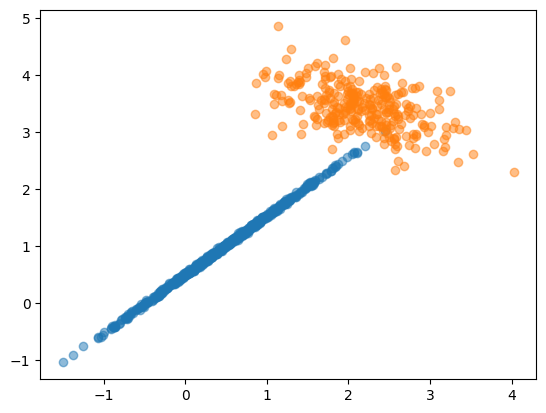

In [154]:
plot_clusters(clusters)


## run the algorithm

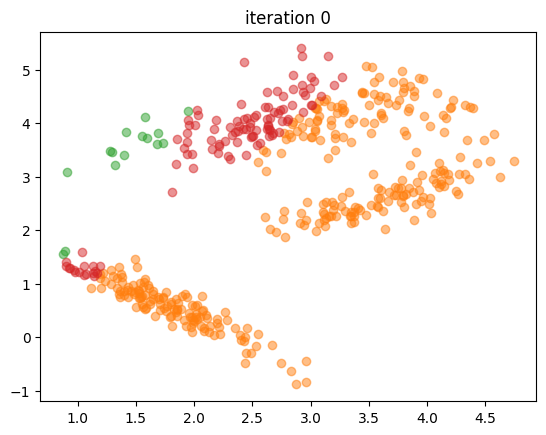

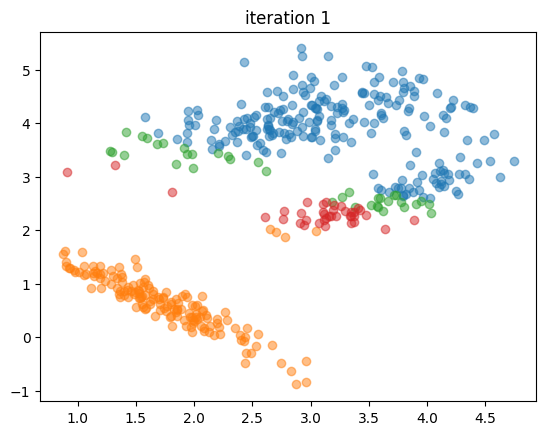

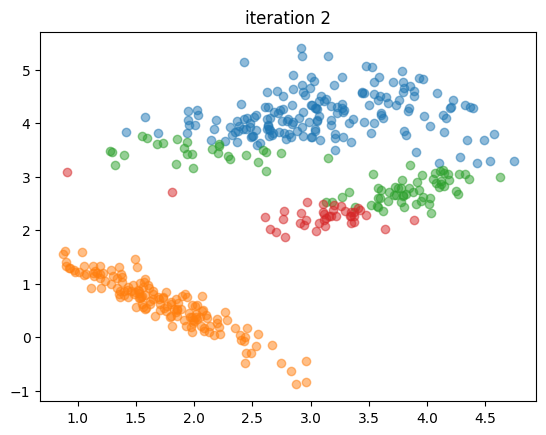

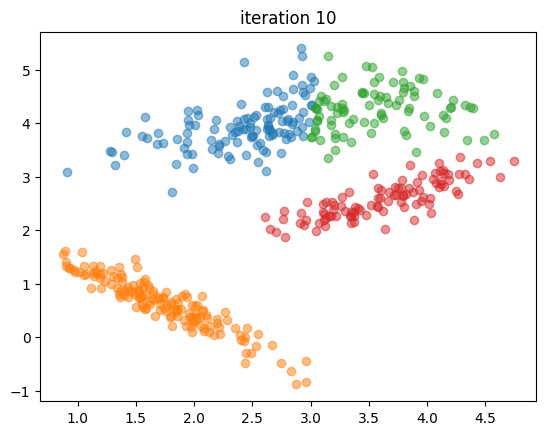

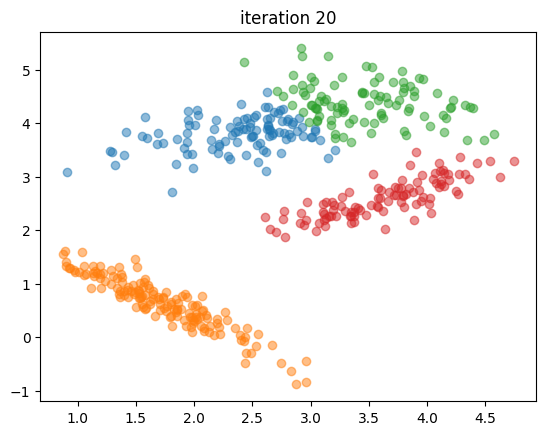

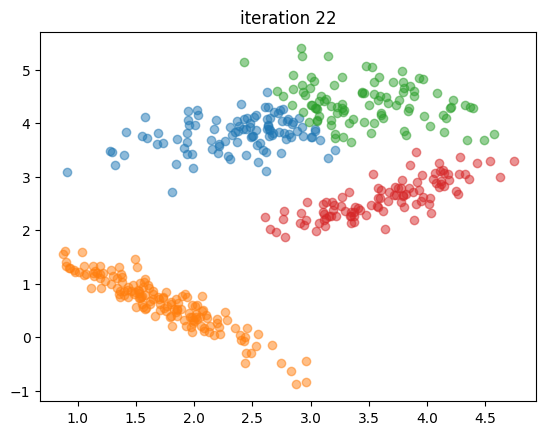

In [199]:
centroids = np.random.rand(K, data.shape[1])

centroids, membership, loss = fcm(data,K,centroids)

# Gath-Geva algorithm

The WUOFC algorithm:

The WUOFC algorithm also known as the GG clustering algorithm is a variant of the FCM algorithm that is used to cluster data points $\{x_i\}_1^n$ when the initialization centers $\{c_j\}_1^n$ are not known, but also when the number of clusters $K$ is not known.
the algorithm, prorposed in the Gath-Geva algorithm paprt, is a six-step algorithm:

1. Initialize the cluster centers. Initialize $K \leftarrow 1$, choose a single initial center $c_1$ at the center of mass of the data, $$c_1 = \frac{1}{N}\sum_{i=1}^N x_i$$
2. while $K < K_{max}$ do:
    - Calculate the new partition:
         - Call FCM with $K$ clusters and the current cluster centers $c_1, \ldots, c_K$. The output of the FCM algorithm is the membership matrix $p(w_j|x_i)$ and the cluster centers $\mu_{cx}$.
        - use the centroids $\mu_{cx}$ as the new cluster centers $c_1, \ldots, c_K$. as the initial cluster centers for the K-Means with exponential kernel algorithm.
    - calculate the cluster validity criteria $V$ for the partition.
    - add a new centroid, $c_{K+1}$ equally distant from all the other centroids, to the set of cluster centers. set $K \leftarrow K+1$.
3. return the partition with the highest validity criteria $V$.

In [299]:
def WUOFC(data, K_max, cluster_validity_criteria, max_iters = 50, fuzziness = 2, tol = 0.001):
    """

    :param data:                        np.array of shape (N,d)
    :param K_max:                       int: maximal feasible number of clusters
    :param cluster_validity_criteria:   fun(list clusters) -> int :function that calculates the cluster validity criteria
    :param max_iters:                   int: maximal number of iterations
    :param fuzziness:                   int: FCM fuzziness parameter
    :param tol:                         int: tolerance parameter
    :return:
    """

    #  Initialize the cluster center c_0
    centroids = [np.mean(data, axis=0)]
    k = 1
    C =[]
    V = []
    while k < K_max:
        # Calculate the membership matrix

        #call FCM with K clusters and the current cluster centers c_1, ..., c_K.
        centroids, membership, loss = fcm(data,k,centroids)

        # use the centroids μcx as the new cluster centers c_1, ..., c_K fo K-means with exponential kernel algorithm.
        #centroids, membership, loss = kmeans_with_exponential_kernel(data, k,centroids, max_iterations=100, gamma=2.0)

        C.append(centroids)
        # calculate the cluster validity criteria V for the partition.
        V.append(cluster_validity_criteria(data, centroids, membership))
        print(f'K = {k} : V = {V[-1]}')

        clusters = [data[np.argmax(membership,axis=1)==i] for i in range(k)]
        plot_clusters(clusters, title=f'K = {k}')
        # add a new centroid, c_K+1 equally distant from all the other centroids, to the set of cluster centers. set K←K+1.
        k += 1
        membership = np.append(membership, np.zeros((membership.shape[0], 1)), axis=1)
        membership[:, -1] = 0.2

        # Calculate the membership matrix

        membership = membership / np.sum(membership, axis=1)[:, None]

        # Update cluster centers
        m = membership ** fuzziness
        centroids = np.dot(m.T, data) / np.sum(m, axis=0)[:, None]



    V_opt = np.argmin(np.array(V))
    C_opt = C[V_opt]
    return V_opt, C_opt

## The trace criterion
the trace criterion is a cluster validity criteria that is used to evaluate the quality of a clustering partition by estimating the sum of variances of the distribution by summing the diagonal elements. the trace criterion is defined as:
$$V = trace(S_W ) = \sum_{k=1}^K trace(S_i) =  \sum_{k=1}^K \frac{1}{N_k}\sum_{i=1}^N p(w_k|x_i) \cdot ||x_i - c_k||^2$$
where $N_k$ is the number of data points in cluster $k$.

In [297]:
def trace_criterion(data, centroids, membership):
    # calculate the covariance matrix for each cluster
    membership = np.array(membership)
    K = membership.shape[1]

    clusters = [data[np.argmax(membership,axis=1)==i] for i in range(K)]

    V = 0
    for k in range(K):
        S_W = np.cov(clusters[k].T)
        V += np.trace(S_W)* (1/clusters[k].shape[0])
    return V


## The determinant criterion
the determinant criterion is a cluster validity criteria that is used to evaluate the quality of a clustering partition by estimating the volume of the distribution. the determinant criterion is defined as:
$$V = \prod_{k=1}^K \left(\frac{1}{N_k}\sum_{i=1}^N p(w_k|x_i) \cdot ||x_i - c_k||^2\right)^{1/d}$$
where $N_k$ is the number of data points in cluster $k$.


# K-Means with exponential kernel
The K-Means with exponential kernel algorithm is a variant of the K-Means algorithm that is used to cluster data points $\{x_i\}_1^n$ when the initialization centers $\{c_j\}_1^n$ are not known, but with known number of clusters $K$ .

In [220]:
def exponential_kernel(x, y, gamma):
    return np.exp(-gamma * np.linalg.norm(x - y)**2)

def kmeans_with_exponential_kernel(data, k,cluster_centers, max_iterations=100, gamma=2.0, plot = False):
    """
    K-Means with exponential kernel
    :param data:            (N, d) nd_array of data points
    :param k:               number of clusters
    :param max_iterations:  maximum number of iterations
    :param gamma:           the exponential decay
    :return:                centroids -
                            labels -
                            loss convergence -
    """
    n_samples, n_features = data.shape

    # Initialize cluster centers randomly
    losses = []

    for iter in range(max_iterations):
        # Assign data points to the nearest cluster center
        u = np.array([np.array([exponential_kernel(x, center, gamma) for center in cluster_centers]) for x in data])
        u = u/ np.sum(u, axis=1)[:, None]

        labels = [np.argmax([exponential_kernel(x, center, gamma) for center in cluster_centers]) for x in data]
        new_cluster_centers = np.zeros((k, n_features))

        # Update cluster centers based on the mean of the data points assigned to each cluster


        # clusters.shape -> (k, n_features)
        new_cluster_centers = np.dot(u.T, data) / np.sum(u, axis=0)[:, None]


        # plot the current iteration

        if plot and (iter < 3 or not iter % 10):
            plot_clusters([data[np.array(labels) == i] for i in range(k)], title=f'iteration {iter}')
            for c in new_cluster_centers:
                plt.scatter(c[0],c[1],marker='x',s=100)

        # Check for convergence
        if np.allclose(cluster_centers, new_cluster_centers):
            break

        cluster_centers = new_cluster_centers
        loss = np.sum([-exponential_kernel(x, cluster_centers[labels[i]], gamma) for i, x in enumerate(data)])
        losses.append(loss)

    return cluster_centers, u, losses




## generate the data

[0.24154958 0.75845042]
(array([0.30561109, 2.48387185]), array([[0.44347901, 0.16370682],
       [0.16370682, 0.25753227]]))


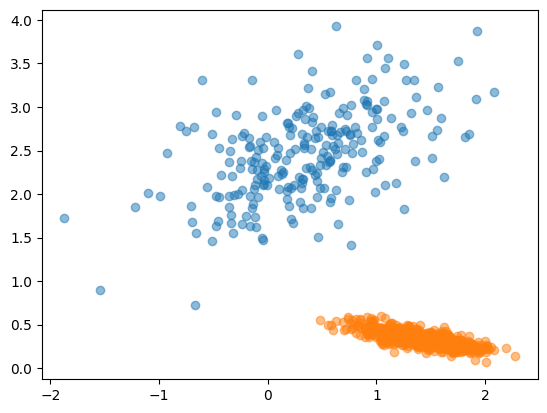

In [182]:

K = 2
d = 2
N = 1000
distance = 4
max_iters = 50
fuzziness = 2

clusters, data, phi, sigma = generate_clusters(K,d,N=N,distance=distance)
plot_clusters(clusters)

## try the algorithm

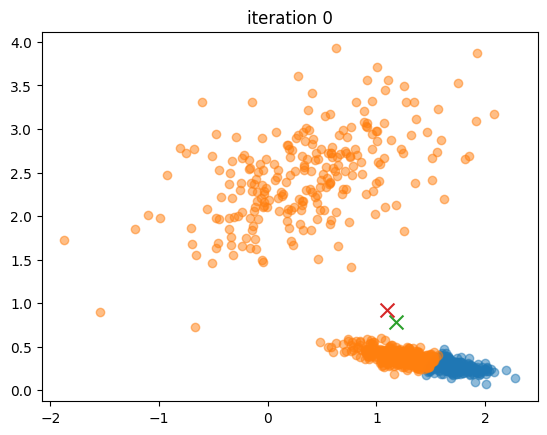

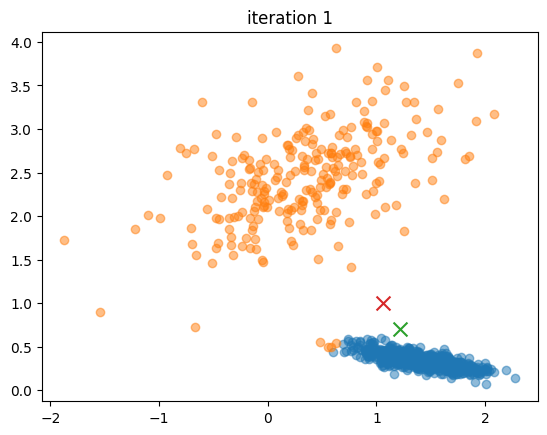

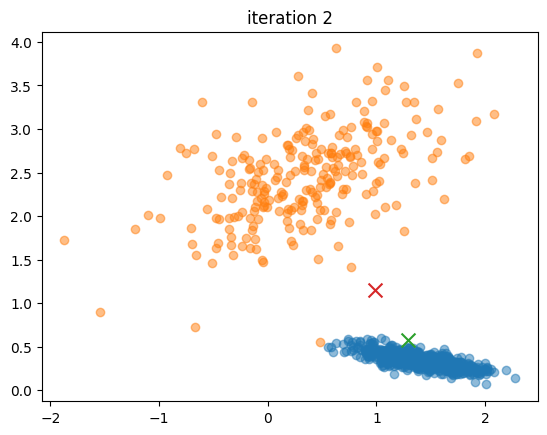

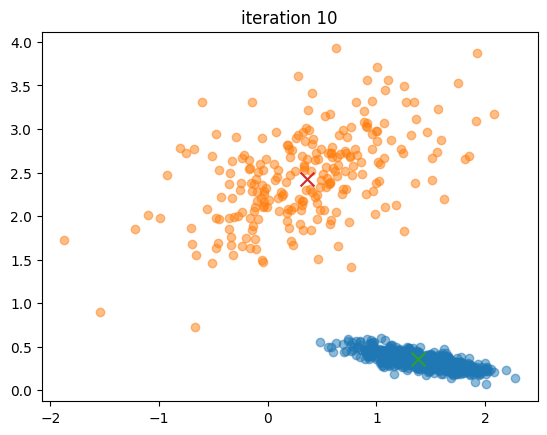

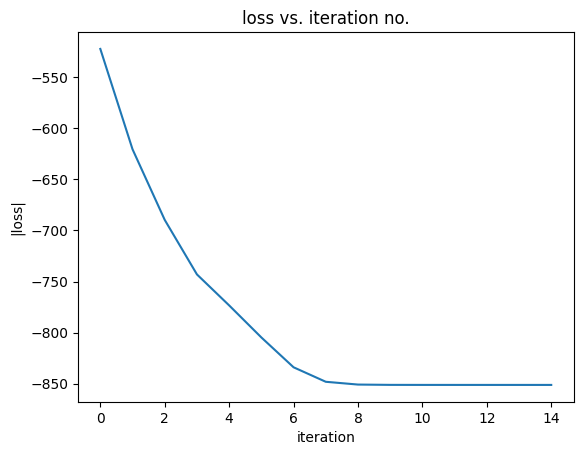

In [183]:
# initialize random centroids
cluster_centers = data[np.random.choice(N, K, replace=False)]

cluster_centers, labels, losses = kmeans_with_exponential_kernel(data, K, cluster_centers,max_iterations=max_iters, gamma=1.0)
plot_loss(losses)

K = 1 : V = 0.007395763749086953
K = 2 : V = 0.009581240280736876
K = 3 : V = 0.010613260147552551
K = 4 : V = 0.013454278238745652
K = 5 : V = 0.015022195829366359
K = 6 : V = 0.017154465059891353


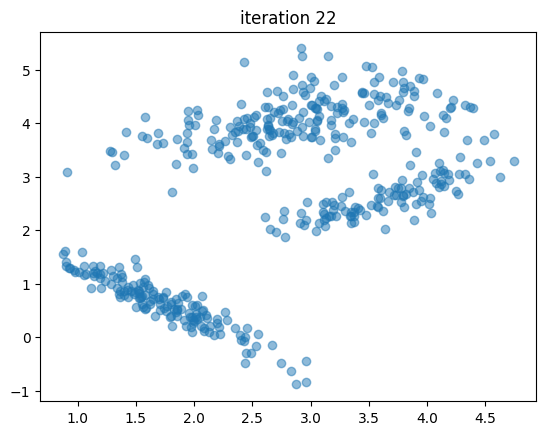

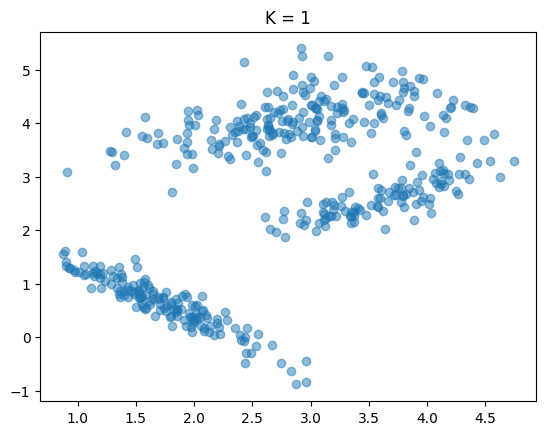

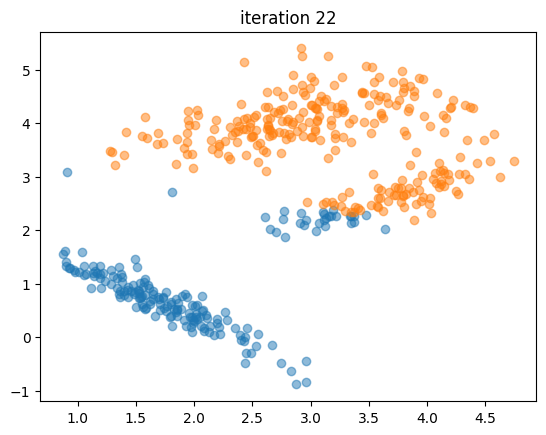

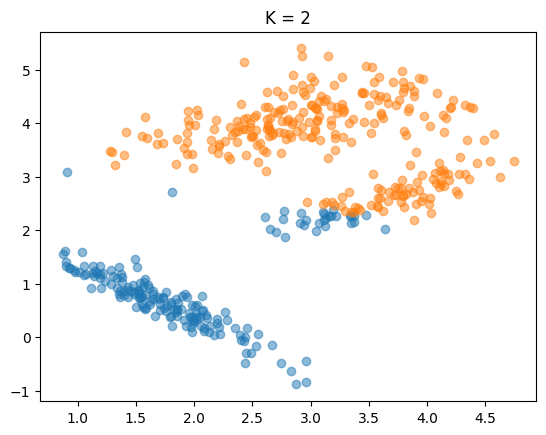

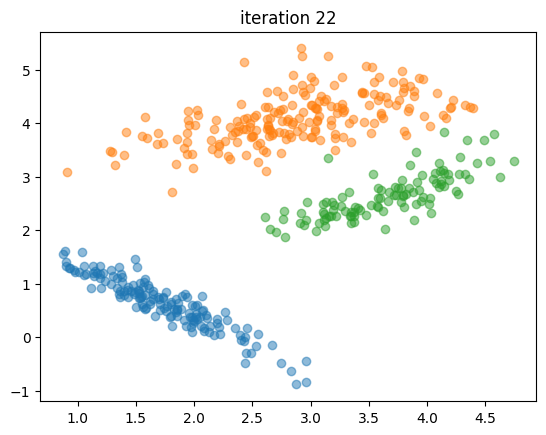

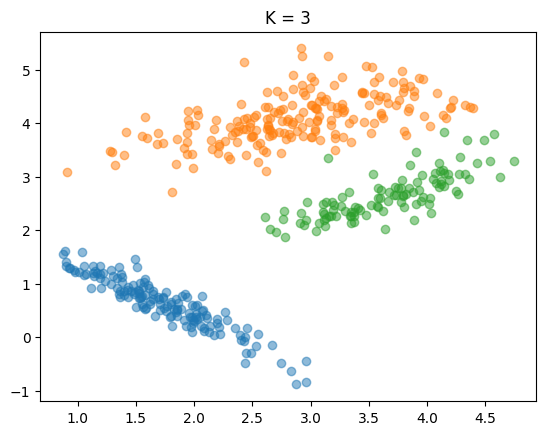

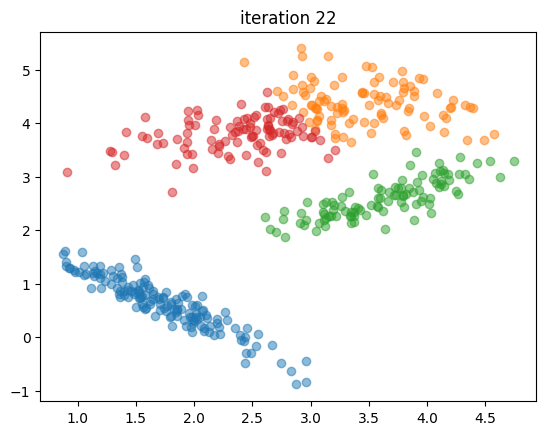

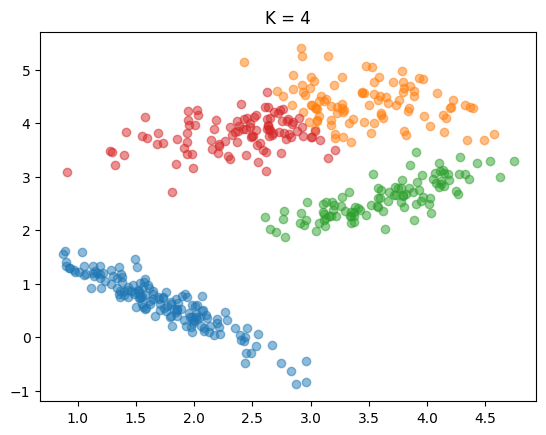

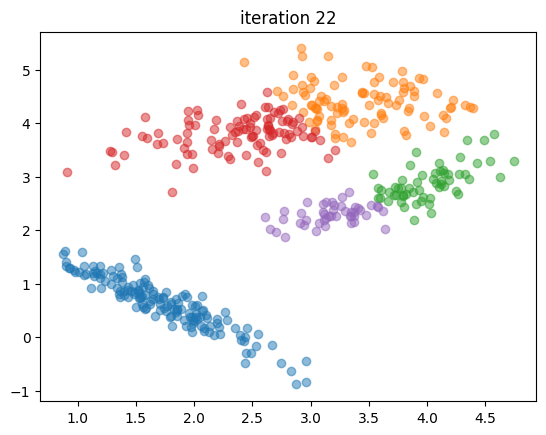

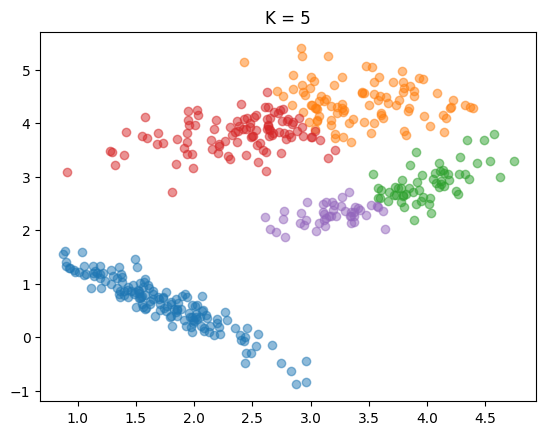

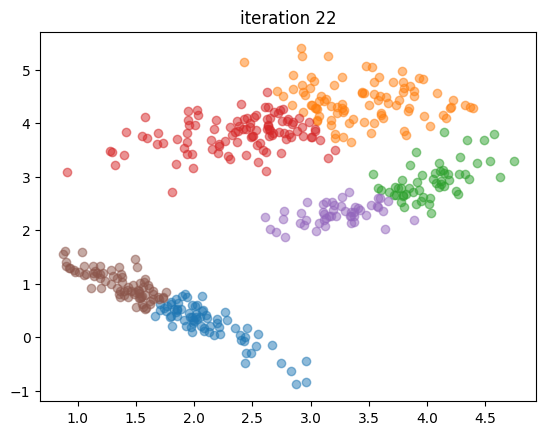

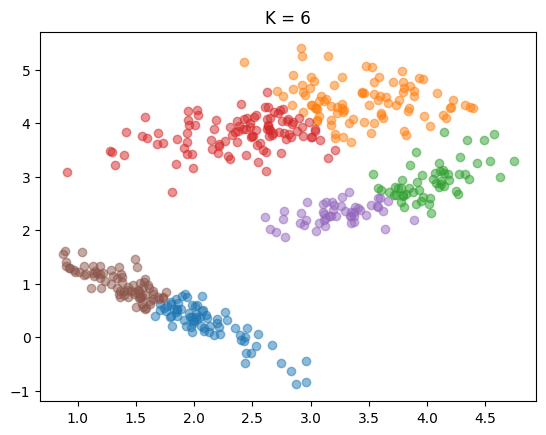

In [300]:
V,C = WUOFC(data, 7, trace_criterion)

## results

## The determinant criterion
the determinant criterion is a cluster validity criteria that is used to evaluate the quality of a clustering partition by estimating the volume of the distribution. the determinant criterion is defined as:
$$V = det \left(\frac{1}{N_k}\sum_{i=1}^N |(x_i - c_k)\cdot(x_i - c_k)^t\right)$$
where $N_k$ is the number of data points in cluster $k$.

In [271]:
def determinant_criterion(data, centroids, membership):
    # calculate the covariance matrix for each cluster
    membership = np.array(membership)
    K = membership.shape[1]

    clusters = [data[np.argmax(membership,axis=1)==i] for i in range(K)]

    V=0
    for c in clusters:
        S_W = np.cov(c.T)
        V += np.linalg.det(S_W) * (1/c.shape[0])
    return V * K

c = [array([[2.67340586, 2.6001596 ]])]
K = 1 : V = 0.0033482262122673874
c = [array([[2.67340586, 2.6001596 ]]), array([[1.74502156, 0.66474931],
       [3.14945101, 3.5925748 ]])]
K = 2 : V = 0.0027082702783440544
c = [array([[2.67340586, 2.6001596 ]]), array([[1.74502156, 0.66474931],
       [3.14945101, 3.5925748 ]]), array([[1.73014967, 0.64477527],
       [2.86957235, 4.09453411],
       [3.62010503, 2.70223346]])]
K = 3 : V = 0.0017012591235034394
c = [array([[2.67340586, 2.6001596 ]]), array([[1.74502156, 0.66474931],
       [3.14945101, 3.5925748 ]]), array([[1.73014967, 0.64477527],
       [2.86957235, 4.09453411],
       [3.62010503, 2.70223346]]), array([[1.72991692, 0.64336381],
       [3.40147496, 4.31119559],
       [3.61054213, 2.62484984],
       [2.38836479, 3.82804165]])]
K = 4 : V = 0.0026749186594622553
c = [array([[2.67340586, 2.6001596 ]]), array([[1.74502156, 0.66474931],
       [3.14945101, 3.5925748 ]]), array([[1.73014967, 0.64477527],
       [2.86957235, 4.0

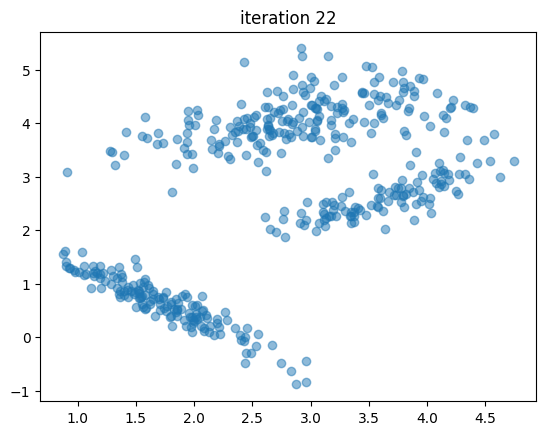

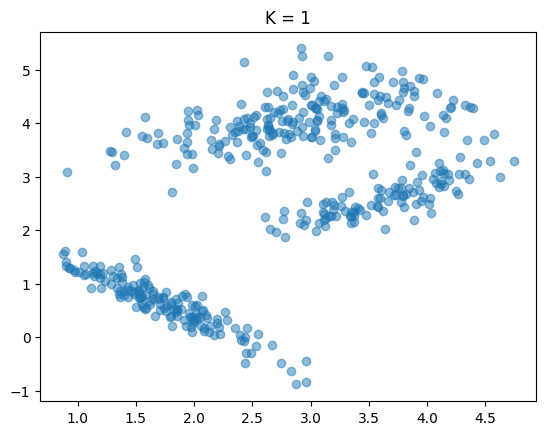

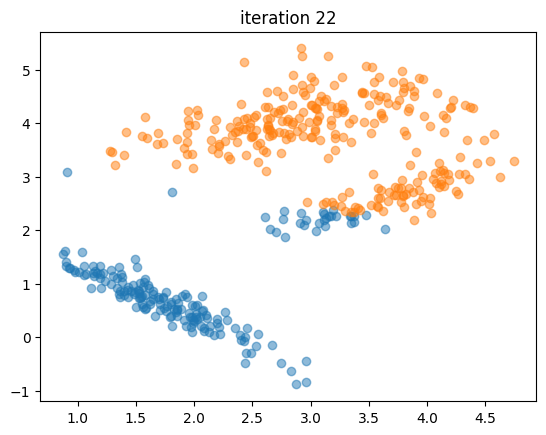

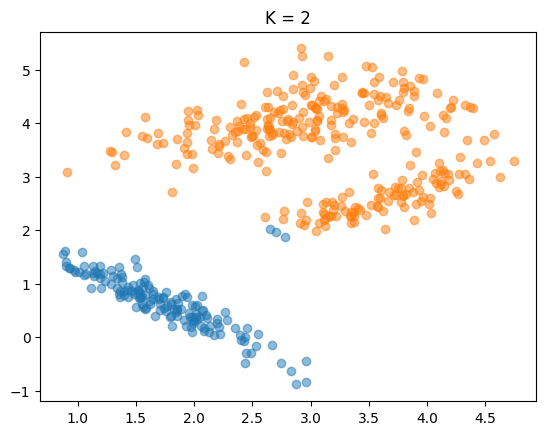

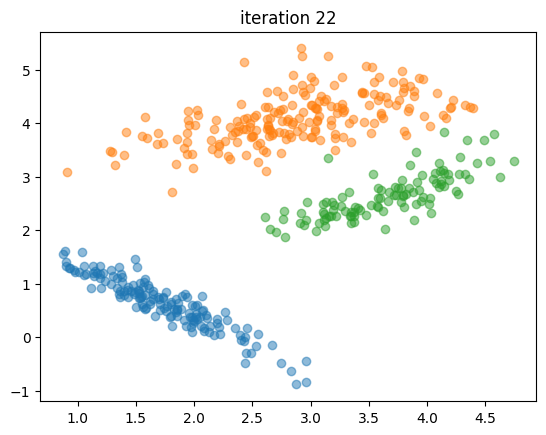

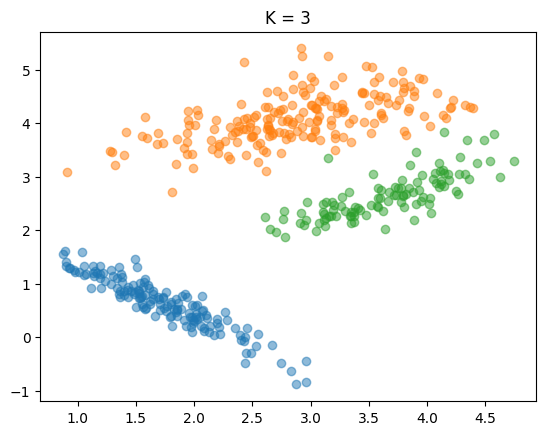

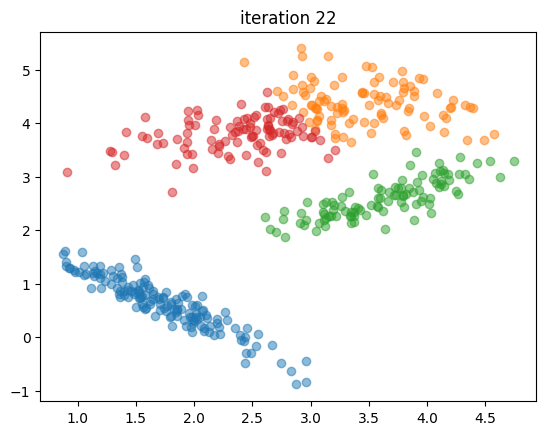

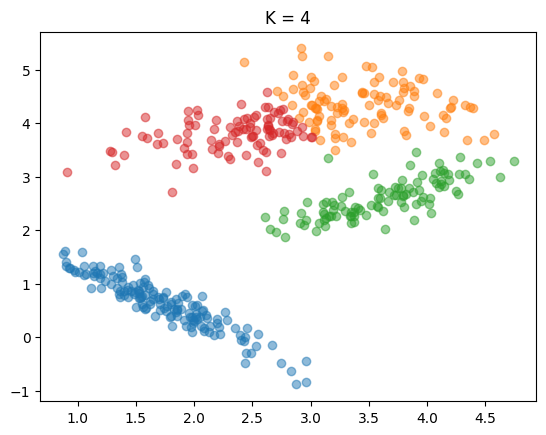

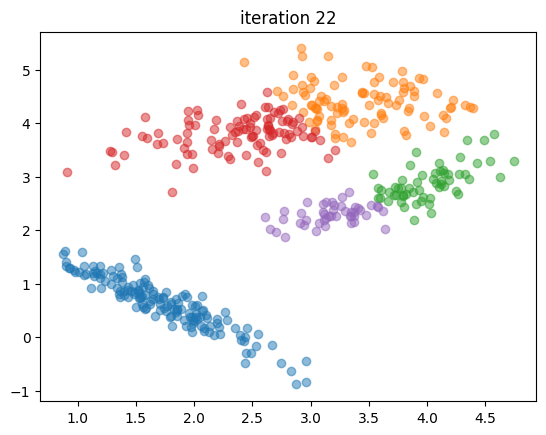

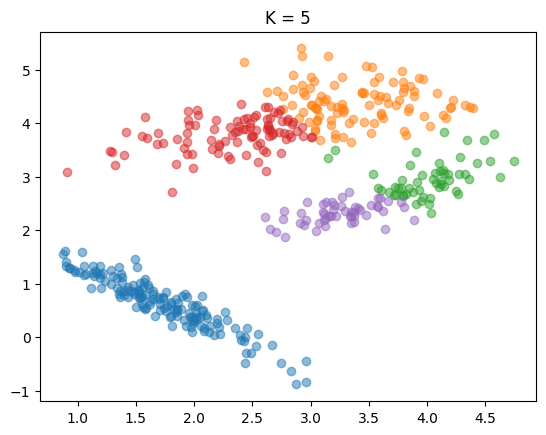

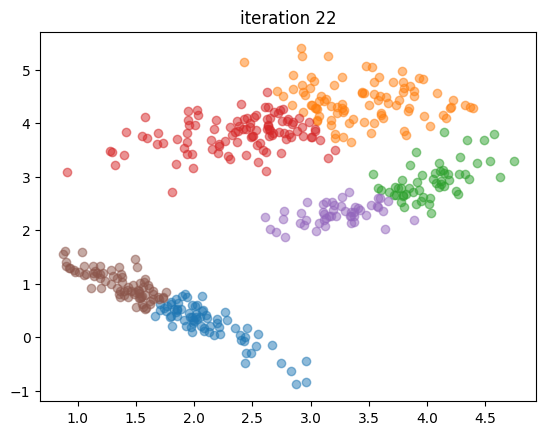

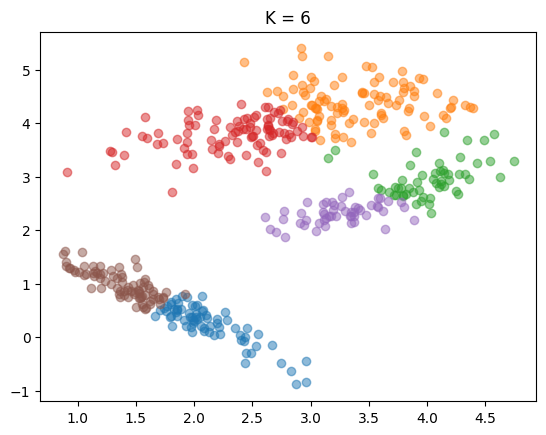

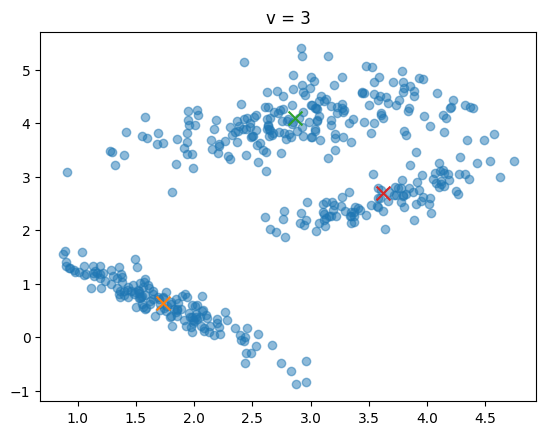

In [296]:
V,C = WUOFC(data, 7, determinant_criterion)
plot_clusters([data],title=f'v = {V+1}')
plot_centroids(C)
